# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Simulation

In [2]:
nside = 64

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [3]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
_, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.


t_list, theta_c_rising, phi_c_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397")
bool_map_rising, integrated_beam_rising = stacked_beam_map(theta_c_rising, 
                                                            phi_c_rising, 
                                                            FWHM=1.1, 
                                                            NSIDE=nside, 
                                                            threshold = 0.0111)

In [4]:
full_bool_map, pixel_indices = reduce_bool_maps_LOR([bool_map_setting, bool_map_rising])
integrated_beam = integrated_beam_setting + integrated_beam_rising

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)
Tsky_operator_rising = generate_Tsky_proj(full_bool_map, theta_c_rising, phi_c_rising, FWHM=1.1)

In [5]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

Number of pixels:  473


### 2. Define Tdiode and Trec

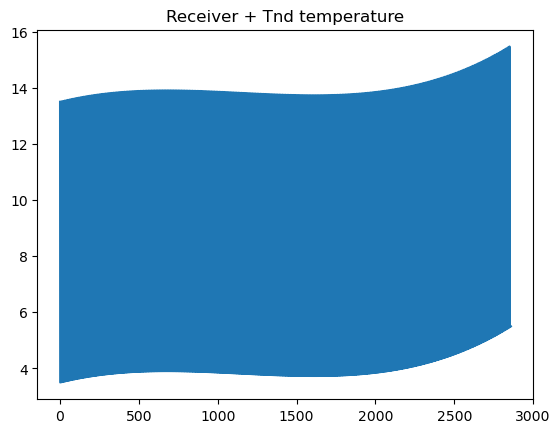

In [6]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ntime = len(t_list)
ndiode_proj = generate_vector(ntime)

nd_rec_operator = np.zeros((ntime, 5))
nd_rec_operator[:, 0] = ndiode_proj    # The noise diode part
nd_rec_operator[:, 1:] = Leg_poly_proj(4, t_list) # The Legendre polynomial (receiver temperature and all) part

T_ndiode = 10.0
rec_params=np.array([4, 0.5, 0.5, 0.5]) # The receiver temperature and all
nd_rec_params = np.zeros(5)
nd_rec_params[0] = T_ndiode
nd_rec_params[1:] = rec_params

plt.title("Receiver + Tnd temperature")
plt.plot(nd_rec_operator @ nd_rec_params)

### 3. Define Gain and Noise

In [7]:
gain_proj = Leg_poly_proj(4, t_list)

#gain_params_setting = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])
gains_setting = gain_proj @ gain_params_setting


#gain_params_rising = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_rising = np.array([6.84507868, 0.14156859, 0.7441104, 0.77863955])
gains_rising  = gain_proj @ gain_params_rising 

# save the gain parameters
np.savez('outputs/GSF5_db/gain_params.npz', gain_params_setting=gain_params_setting, gain_params_rising=gain_params_rising)

In [8]:
dtime = 2
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)
alpha = 2.0
logf0_list=[-4.874571109426952, -3.874259892646189, -2.901434432609383] 
# Corresponding to knee frequencies: 0.001. 0.01, 0.1
sigma_2 = 1/(4e5)

f0 = 10**logf0_list[0]

noise_setting = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)
noise_rising = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)

In [9]:
Tsys_setting = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_setting = Tsys_setting * (1+noise_setting) * gains_setting

Tsys_rising = Tsky_operator_rising @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_rising = Tsys_rising * (1+noise_rising) * gains_rising

## B. Sampling

In [10]:
def reduce_bool_maps_LAND(bool_maps):
    """
    Reduce a list of boolean maps using the "logical and" operation.
    """
    reduced_map = np.logical_and.reduce(bool_maps)
    # Get the pixel indices of the "1" pixels:
    pixel_indices = np.where(reduced_map)[0]
    return reduced_map, pixel_indices

In [11]:
# Convert theta/phi coordinates to HEALPix pixels
pixels_c_setting = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
          for theta, phi in zip(theta_c_setting, phi_c_setting)]
bool_map_c_setting = np.zeros(hp.nside2npix(nside))
bool_map_c_setting[pixels_c_setting] = 1

# Convert theta/phi coordinates to HEALPix pixels
# pixels_c_rising = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
#           for theta, phi in zip(theta_c_rising, phi_c_rising)]
# bool_map_c_rising = np.zeros(hp.nside2npix(nside))
# bool_map_c_rising[pixels_c_rising] = 1

# LAND_bool_map, shared_pixel_indices = reduce_bool_maps_LAND([bool_map_c_setting, bool_map_c_rising])
# shared_indices = [list(pixel_indices).index(item) for item in shared_pixel_indices]

# # For a 1D array 'integrated_beam_setting'
# n_cal_pixs=1
# top_20_beam_indices = np.argpartition(integrated_beam[pixel_indices], -20)[-20:]
# top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
# calibration_indices = top_20_beam_indices[top_n_sky_indices]

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam[pixel_indices], -200)[-200:]
calibration_indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]

In [12]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.ones(4)*0.
gain_prior_cov_inv[0] = 2.
gain_prior_mean = gain_params_setting

Tsky_prior_cov_inv = np.ones_like(sky_params)*0.2
Tsky_prior_cov_inv[calibration_indices] = 1e20

# Trec_prior_cov = np.ones_like(nd_rec_params)
# Trec_prior_cov[0] = 10.
Trec_prior_cov = np.zeros_like(nd_rec_params)
Trec_prior_cov_inv_list = [Trec_prior_cov, Trec_prior_cov]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [13]:
# class TOD_sim:
#     def __init__(self, t_list, theta_c, phi_c, 
#                  TOD, gain_proj, Tsky_proj, nd_rec_proj,
#                  ):
#         self.t_list = None
#         self.theta_c = None
#         self.phi_c = None

In [14]:
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting, TOD_rising],
                                    [t_list, t_list],
                                    [gain_proj, gain_proj],
                                    [Tsky_operator_setting, Tsky_operator_rising],
                                    [nd_rec_operator, nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc, logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv_list,
                                    local_Trec_prior_mean_list=[nd_rec_params, nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv,gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_params_setting,gain_params_rising],
                                    local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=300,
                                    tol=1e-12)

Rank: 0, local id: 0, gain_sample 0: [6.31201917 0.42013905 0.26609378 0.05461196]
emcee: Exception while calling your likelihood function:
  params: [-5.03200455  1.96332234]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zzhang/Workspace/flicker/notebooks/../hydra_TOD/mcmc_sampler.py", line 97, in log_prob
    return log_like(params) + prior_function(params)
           ~~~~~~~~^^^^^^^^
  File "/Users/zzhang/Workspace/flicker/notebooks/../hydra_TOD/noise_sampler_fixed_fc.py", line 66, in log_like
    corr_list = flicker_cov_vec(tau_list, 10.**logf0, 10.**logfc, alpha,  white_n_variance=wnoise_var)
  File "/Users/zzhang/Workspace/flicker/notebooks/../hydra_TOD/flicker_model.py", line 106, in flicker_cov_vec
    result[1:] = flicker_corr_vec(tau_list[1:], f0, fc, alpha)
                 ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zzhang/Workspace/flicker/notebooks/../hydra_TOD/flicker_model.py", line 99, in flicker_corr_v

KeyboardInterrupt: 

#### Visualize the Tsky samples

In [ ]:
# First, save the samples as npy files..

np.save("outputs/GSF5_db/Tsys_samples.npy", Tsys_samples)
np.save("outputs/GSF5_db/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GSF5_db/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [ ]:
Tsys_samples = np.load('outputs/GSF5_db/Tsys_samples.npy')
gain_samples = np.load('outputs/GSF5_db/gain_samples.npy')
noise_samples = np.load('outputs/GSF5_db/noise_samples.npy')


In [ ]:
num_pixels = len(pixel_indices)
Tsky_samples = Tsys_samples[:, :num_pixels]
other_samples = np.hstack((gain_samples[0], Tsys_samples[:, num_pixels:], noise_samples[0]))
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)
Tresidual = Tmean - sky_params


NPIX = hp.nside2npix(nside)

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = sky_params
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd

The mean residual is:  -0.012114786200583443
16th percentile:  -0.20147069035479248
84th percentile:  0.126210745547561


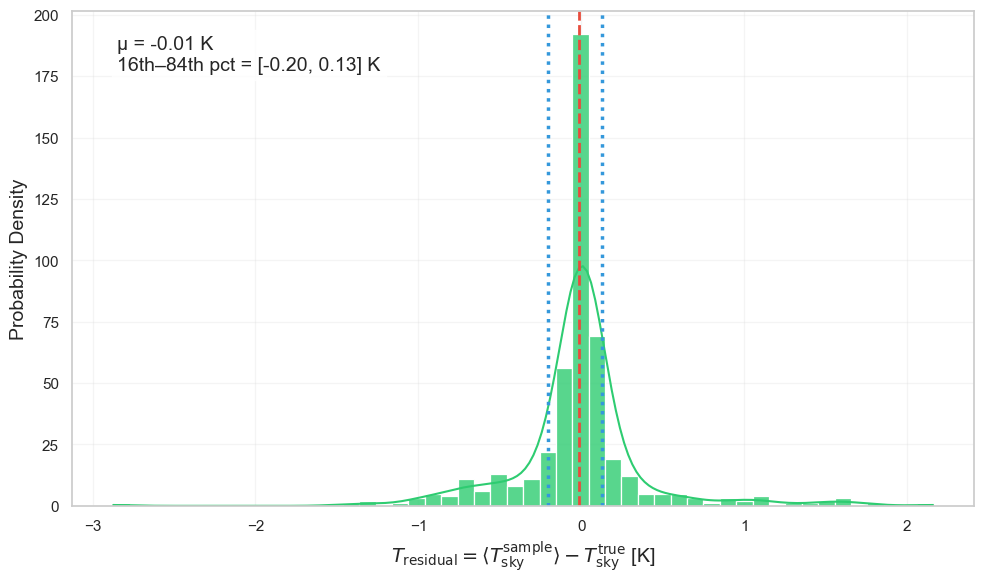

In [ ]:
# Calculate residuals
residuals = Tmean - sky_params
from visualisation import *
plot_residual_histogram(residuals, save_path="./GSF5_db_residuals_histogram.pdf")